In [53]:
import plotly.graph_objects as go
import datetime
from datetime import datetime
import random
import calendar
import time
from subprocess import call
import sklearn
from matplotlib.lines import Line2D
import statsmodels.tsa.stattools as ts
import matplotlib.ticker as mtick
import matplotlib.collections as collections
from numpy import linalg
from IPython.display import Image
import os
import graphviz
import sys
import csv
import pandas as pd 
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import numpy as np
import warnings
from sklearn.tree import export_graphviz
from sklearn import datasets
warnings.filterwarnings("ignore")
import math
import operator
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.font_manager as fm
from sklearn import preprocessing
from sklearn import linear_model
from statsmodels.tsa.arima_model import ARIMA
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy import stats
from copy import deepcopy
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from datetime import datetime
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.feature_extraction import DictVectorizer
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import cross_validate

from WindPy import w
w.start()
#趋势划分函数

def und(data, l1, l2):
    i = 0
    res = [0] * len(data)

    while i < len(data)-1:
        if i + l1 >= len(data) - 1:
            for j in range(i, len(data)):
                res[j] = res[i]
            break
        cur = data[i]
        
        next_id = min([(data).index(max(data[i+1+l1:i+1+l2])), data.index(min(data[i+1+l1:i+1+l2]))])
        res[i:next_id+1] = [- (-1) ** (data[next_id] > data[i])] * (next_id + 1 - i)
        i = next_id
    return res

#移动平均线MA
def ma(data, l_ma):
    res = []
    for i in range(l_ma-1,len(data)):
        res.append(np.mean(data[i-l_ma+1:i+1]))
    return res

#ROCSMA变化率移动平均
def rocsma(d1,i1,l_roc,l_sma):
    res = 0
    for x in range(l_sma):
        res += (d1[i1-x-1]/d1[i1-x-l_sma-1]-1)/l_sma
    return res

#KST公式
def kst(d2,i2,roc_l1,roc_l2,roc_l3,roc_l4,sma_l1,sma_l2,sma_l3,sma_l4):
    rocma1 = rocsma(d2,i2,roc_l1,sma_l1)
    rocma2 = rocsma(d2,i2,roc_l2,sma_l2)
    rocma3 = rocsma(d2,i2,roc_l3,sma_l3)
    rocma4 = rocsma(d2,i2,roc_l4,sma_l4)
    return (rocma1 * 1 + rocma2 * 2 + rocma3 * 3 + rocma4 * 4)
    

#相对强度
def rel_str(data, i1, i2):
    return (np.array(data[i1])/np.mean(data[i1])) / (np.array(data[i2])/np.mean(data[i2]))

#交叉变换趋势
def cross(d1,d2,cd):
    comp = [-(-1) ** (d1[i] > d2[i]) for i in range(len(d1))]
    res = [-comp[0]]
    c = 0
    
    for i in range(1,len(comp)):
        if comp[i] * comp[i-1] == -1 and c == 0:
            sl1 = -(-1)**(d1[i]>d1[i-1])
            sl2 = -(-1)**(d2[i]>d2[i-1])
            res.append(sl1*sl2)
            c += cd
        else:
            res.append(res[-1])
            c = max(0,c-1)
    return res

#大小对比
def comp(d1,d2):
    res = [-(-1) ** (d1[i] > d2[i]) for i in range(len(d1))]
    return res

#标准化
def std(data):
    res = []
    for i in range(len(data)):
        res.append((data[i] - np.mean(data[:i+1]))/np.mean(data[:i+1]))
    return res

#普林格经济周期
def pring(b,s,c):
    if b == 1 and s == c == -1:
        return -3
    if b == s == 1 and c == -1:
        return -1
    if b == s == c == 1:
        return 1
    if b == -1 and s == c == 1:
        return 3
    if b == s == -1 and c == 1:
        return 1
    if b == s == c == -1:
        return -1
    else:
        return 0

def dupe_legend(label, color):
    line = Line2D([0], [0], linestyle='none', mfc= 'white',
                mec=color, marker=r'$\mathregular{{{}}}$'.format(label))
    return line

#平滑折线
def smooth(data):
    for i in range(len(data)-4):
        if data[i] * data[i+2] == 1 and data[i] * data[i+1] == -1:
            data[i+1] = data[i]
        elif data[i] * data[i+3] == 1 and all(data[i+1:i+3]) != data[i]:
            for j in range(2):
                data[i+j+1] = data[i]
        elif data[i] * data[i+4] == 1 and all(data[i+1:i+4]) != data[i]:
            for j in range(3):
                data[i+j+1] = data[i]
    return data

def smooth2(data):
    for i in range(len(data)-5):
        if data[i] * data[i+5] == 1 and all(data[i+1:i+4]) != data[i]:
            for j in range(4):
                data[i+j+1] = data[i]
    return data
    
######################################评估方式

#准确度计算
def acc(d1,d2):
    return round(sum(np.array(d1) == np.array(d2))/ len(d1),3)

#收益率计算
def profit(data, ud):
    money = 1
    num = 0
    prt = 0   #显示路径
    for i in range(len(data)):
        if ud[i] == 1 and num == 0:
            if prt:
                print('in', date[11:][i], 'money', money, 'num', num, 'price', data[i])
            num = money/data[i]
            money = 0
        if ud[i] != 1 and money == 0:
            if prt:
                print('out', date[11:][i], 'money', money, 'num', num, 'price', data[i])
            money = num * data[i]
            num = 0
    if prt:
        print(max(money,num*data[-1]))
    return max(money,num*data[-1])

#复杂度计算
def cpx(x):
    res = 1
    dirc = x[0]
    for i in range(len(x)):
        if x[i] != dirc:
            res += 1
            dirc = x[i]
    return res/len(x)


def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeSeries.rolling(window=size).mean()
    # 对size个数据进行加权移动平均
    rol_weighted_mean = pd.ewma(timeSeries, span=size)

    timeSeries.plot(color='blue', label='Original')
    rolmean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()

def draw_ts(timeSeries):
    f = plt.figure(facecolor='white')
    timeSeries.plot(color='blue')
    plt.show()

'''
　　Unit Root Test
   The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
   root, with the alternative that there is no unit root. That is to say the
   bigger the p-value the more reason we assert that there is a unit root
'''
def testStationarity(ts):
    dftest = adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

# 自相关和偏相关图，默认阶数为31阶
def draw_acf_pacf(ts, lags=31):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=31, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=31, ax=ax2)
    plt.show()
    
    
    
    
    
def tsplot(y, lags=None, figsize=(10,8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):#定义局部样式
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (2,0))
        pp_ax = plt.subplot2grid(layout, (2,1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)#自相关系数ACF图
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)#偏相关系数PACF图
        sm.qqplot(y, line='s', ax=qq_ax)#QQ图检验是否是正太分布
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return
    

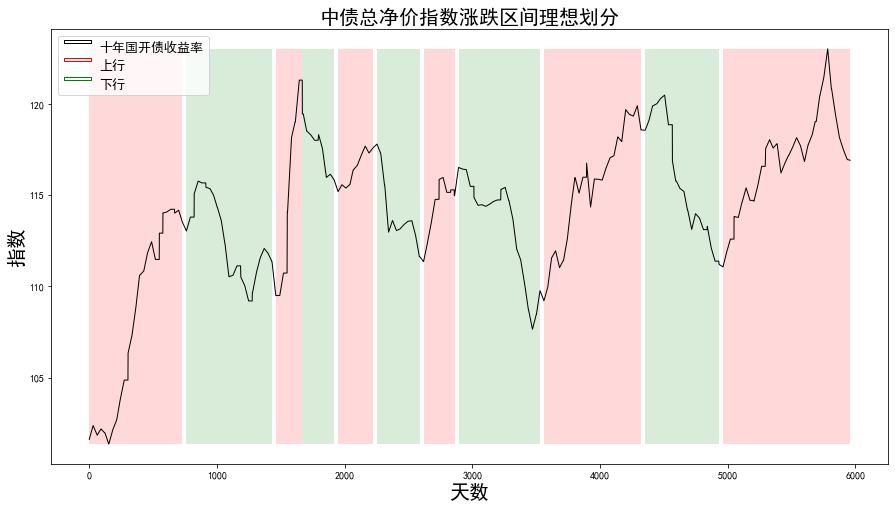

理想收益率 1.483


In [2]:
int_list = [['M0020188','股票'],['S0105896','商品'],['M0265832','中债总净价指数'],['G1000116','OECD'],['M0043815','短贷利率']]

#起止时间
t0 = '2004-06-01'
t1 = '2020-10-01'

#指数取值周期
dic = {'D':'天', 'W':'周', 'M':'月', 'Q':'季度', 'S':'半年', 'Y':'年'}
prd = 'M'

#移动平均线平均时长
l = 12

ind_list = []
for i in int_list:
    ind_list.append(i[0])
    
og = w.wsd(ind_list, 'close', t0, '-1D', Period = prd, Fill = 'Previous')

#训练比例
r = .5

#指数与日期
data = og.Data
date = og.Times

df = []
d8 = []

for i in range(len(date)):
    d8.append(int((date[i] - date[0]).days))

################################    


ud = und(data[2],12,24)
base_cpx = cpx(ud)
    
plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('中债总净价指数涨跌区间理想划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[2], color='black', linewidth = 1, label = '十年国开债收益率')

plt.xlabel(u'天数',fontproperties='SimHei',fontsize = 20)
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8, ymin=min(data[2]), ymax=max(data[2]), where=np.array(ud) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8, ymin=min(data[2]), ymax=max(data[2]), where=np.array(ud) == -1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)


new_legends = ["-", "-", "-"]
markers = ['-', '-','-']
colors = ['black', 'red', 'green']

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()
print('理想收益率',round(profit(data[2],ud),3))
####################

df = []

#从第l个周期开始
for i in range(l-1,len(date)):
    temp = []
        
    for j in range(len(data)):
        
        #选取第j组第i+l时间点前l长度的数据
        il = data[j][i-l+1:i+1]
        
        #第i+l时间点前l长度的涨跌幅度及方向————0
        temp.append(il[-1]/il[0]-1)
        
        #第i+l时间点前l长度内的最大波动幅度————1
        temp.append(((max(il)-min(il))/np.mean(il)))
        
        #第i+l时间点前l长度内的反转频率————2
        spike = 0
        dirc = -(-1) ** (il[1] > il[0]) 
        for k in range(1,l):
            spike += (-(-1) ** (il[k] > il[k-1]) != dirc)
            dirc = -(-1) ** (il[k] > il[k-1])
        temp.append(spike)
              
        #第i+l时间点l个时长的移动平均值————3
        temp.append(np.mean(il))    
        
        #第i+l时间点的数据————4
        temp.append(data[j][i])

    df.append(temp)
    

x = [i[::] for i in df]

train_x, valid_x, train_y, valid_y = x[:int(len(x)*r)], x[int(len(x)*r):], (ud[l-1:])[:int(len(x)*r)], (ud[l-1:])[int(len(x)*r):]

# 移动平均

# 随机森林

通过证券的动量与震荡指标判断当前时间点的市场趋势，包括12个月的移动平均值，变化率，极值差，反转频率。

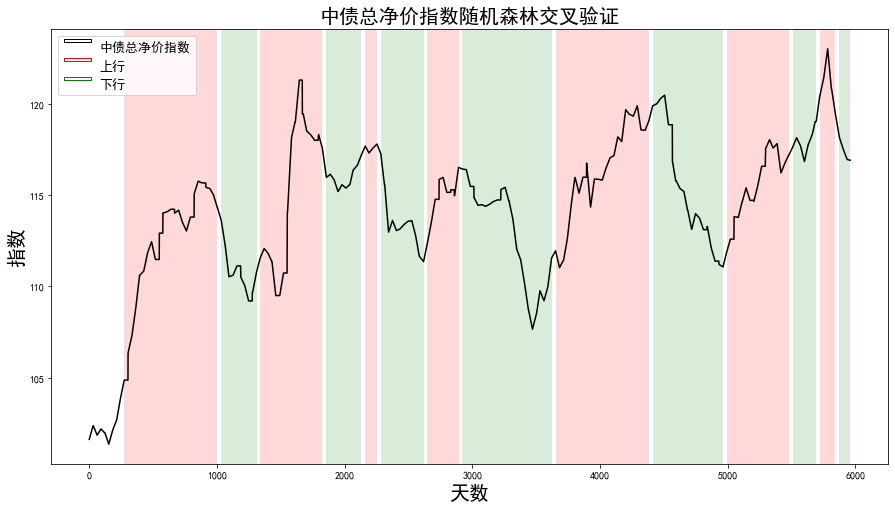

收益率 1.285
相对收益率 0.894
准确率 0.769
复杂度 1.327


In [67]:
#选择变量
b_i = []

for i in range(len(df)):
    temp = []
    for j in range(10,12):
        temp.append(df[i][j])
    b_i.append(temp)

l1 = 100
h1 = 130
    
#随机森林
ud_rf_b = [0] * len(b_i)
ng = 4
for i in range(ng):
    train_x = b_i[i*65:(i+1)*65]
    train_y = ud[11:][i*65:(i+1)*65]
    valid_x = b_i[0:i*65] + b_i[(i+1)*65:len(b_i)]
    valid_y = ud[11:][0:i*65] + ud[11:][(i+1)*65:len(b_i)]
    
    rf=RandomForestRegressor(n_estimators = 500)
    rf.fit(train_x, train_y)
    rf_prd = np.array(-(-1) ** (rf.predict(valid_x) >= 0)) 

    aaa1 = rf_prd[0:i*65]
    aaa2 = rf_prd[i*65:len(rf_prd)]
    
    ud_rf_b[0:i*65] += aaa1
    ud_rf_b[(i+1)*65:len(b_i)] += aaa2

ud_rf_b = smooth(-(-1) ** (np.array(ud_rf_b) > 0))
l_rf = len(d8) - len(ud_rf_b)

plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('中债总净价指数随机森林交叉验证',fontproperties='SimHei', size = 20)
ax.plot(d8, data[2], color='black', linewidth = 1.5, label = '中债总净价指数')

plt.xlabel(u'天数',fontproperties='SimHei',fontsize = 20)
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_rf:], ymin=l1, ymax=h1, where=np.array(ud_rf_b) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[l_rf:], ymin=l1, ymax=h1, where=np.array(ud_rf_b) == -1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black','red', 'green']
new_legends = ['-'] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

p1 = round(profit(data[2][11:],ud_rf_b),3)
rp1 = round(profit(data[2][11:],ud_rf_b)/profit(data[2][11:], ud[11:]),3)
a1 = round(acc(ud_rf_b, ud[11:]),3)
c1 = round(cpx(ud_rf_b)/base_cpx,3)

print('收益率', p1)
print('相对收益率', rp1)
print('准确率', a1)
print('复杂度', c1)

In [68]:
#利用选择的变量预测
rf_res = []
b_i = []
for i in range(len(df)):
    b_i.append([df[i][10],df[i][11],df[i][12]])

for i in range(len(df)-59):
    rf = RandomForestRegressor(n_estimators = 100)
    rf = rf.fit(b_i[i:i+59], ud[i+11:i+70])
    rf_res.append(rf.predict([b_i[i+59]]) >= 0)

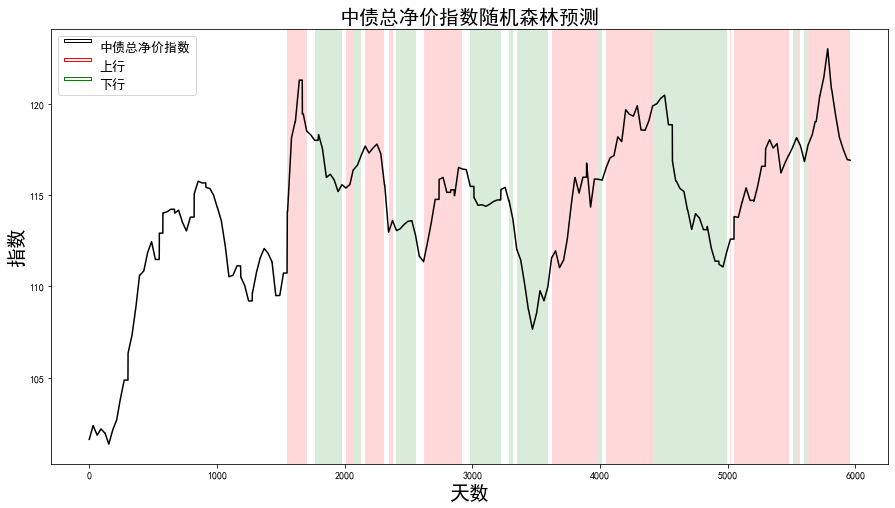

收益率 1.148
相对收益率 0.897
准确率 0.826
复杂度 3.8


In [69]:
rf_res = [(-(-1) ** int(i > 0)) for i in rf_res]   

plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('中债总净价指数随机森林预测',fontproperties='SimHei', size = 20)
ax.plot(d8, data[2], color='black', linewidth = 1.5, label = '中债总净价指数')

plt.xlabel(u'天数',fontproperties='SimHei',fontsize = 20)
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8[70:], ymin=l1, ymax=h1, where=np.array(rf_res) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[70:], ymin=l1, ymax=h1, where=np.array(rf_res) != 1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black','red', 'green']
new_legends = ['-'] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

p1 = round(profit(data[2][70:],rf_res),3)
rp1 = round(profit(data[2][70:],rf_res)/profit(data[2][70:], ud[70:]),3)
a1 = round(acc(rf_res, ud[70:]),3)
c1 = round(cpx(rf_res)/base_cpx,3)

print('收益率', p1)
print('相对收益率', rp1)
print('准确率', a1)
print('复杂度', c1)

[1]


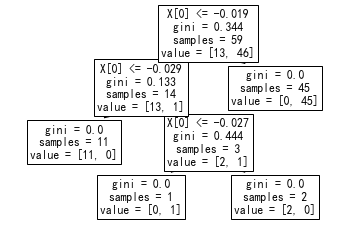

In [70]:
from sklearn import tree
tre = DecisionTreeClassifier()
tre.fit(b_i[-60:-1], ud[-60:-1])
print(tre.predict([b_i[-1]]))
tree.plot_tree(tre)
dot_data = tree.export_graphviz(tre, out_file="tre.dot") 

#dot -Tpng tre.dot -o tre.png

# 时间序列

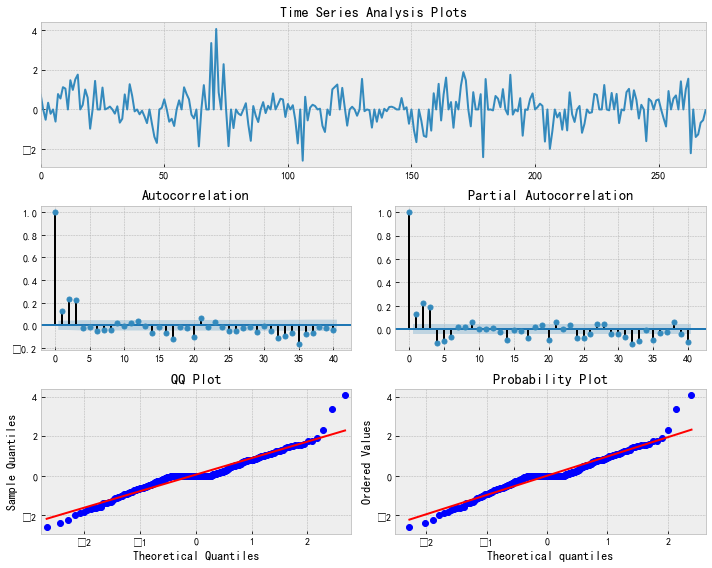

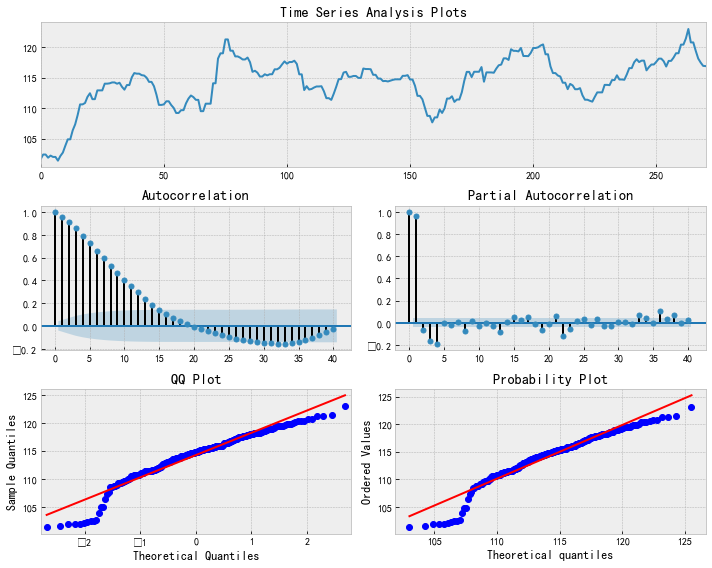

In [66]:
tr = data[2]
tsplot(np.diff(tr,1), lags=40)
tsplot(tr, lags=40)

# 滤波

# 神经网络

In [75]:
D = 5 # dimensionality
K = 2 # number of classes
X = np.array([i[10:15] for i in df]) # data matrix (each row = single example)
y = np.array(deepcopy(ud[11:])) # class labels

# Train a Linear Classifier

# initialize parameters randomly
h = 20
W = .01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = .01 * np.random.randn(h,K)
b2 = np.zeros((1,K))



# define some hyperparameters
step_size = 1
reg = 1e-2 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(1000):

    # evaluate class scores, [N x K]
    hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
    # print np.size(hidden_layer,1)
    scores = np.dot(hidden_layer, W2) + b2

    # compute the class probabilities
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

    # compute the loss: average cross-entropy loss and regularization
    corect_logprobs = -np.log(probs[range(num_examples),y])
    data_loss = np.sum(corect_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
    loss = data_loss + reg_loss

    # compute the gradient on scores
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples

    # backpropate the gradient to the parameters
    # first backprop into parameters W2 and b2
    dW2 = np.dot(hidden_layer.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)
    # next backprop into hidden layer
    dhidden = np.dot(dscores, W2.T)
    # backprop the ReLU non-linearity
    dhidden[hidden_layer <= 0] = 0

    # finally into W,b
    dW = np.dot(X.T, dhidden)
    db = np.sum(dhidden, axis=0, keepdims=True)

    # add regularization gradient contribution
    dW2 += reg * W2
    dW += reg * W

    # perform a parameter update
    W += -step_size * dW
    b += -step_size * db
    W2 += -step_size * dW2
    b2 += -step_size * db2

# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)

print(np.mean(predicted_class == y))

0.0


# 结果总结